# Software Developer Trends 








### Business Understanding

The data used is from the 2020 stack overflow developer survey where almost 65,000 developers answered a series of question related their demographics the tools they use, and what they value and how they study. 

This project looks at 3 mean questions: 

1. Are they developers in United States paid more or less the same than rest of world
2. Are the developers in the United States happy when compared to the rest of the world
3. What drives developers in the United States to look for a new job vs. The Rest of the World (i.e., what's most important to American job seekers)


The project pulls all the survey data from Google Drive using the library Googledrivedownloader.  It also explores various aspects of the data and cleans the data by handling missing values. It then shapes the data then project then plots the results. The data preparation, modeling, and evaluation process is done for each of the 3 questions.

## Data Analysis

In [32]:
#Import Packages 
#!pip install pandasql
!pip install googledrivedownloader
import pandasql
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from matplotlib.colors import ListedColormap
import warnings
from google_drive_downloader import GoogleDriveDownloader as gdd
warnings.filterwarnings('ignore')





### Data Understanding 

In [2]:
gdd.download_file_from_google_drive(file_id='1dfGerWeWkcyQ9GX9x20rdSGj7WtEpzBB',
                                    dest_path='./data/stackoverflow.zip',
                                    unzip=True)

In [3]:
survey_results_df = pd.read_csv('./data/survey_results_public.csv')

In [4]:
#Check that data frame imported and explore column names
survey_results_df.head()
survey_results_df.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq',
       'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc',
       'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith',
       'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',
       'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
  

In [5]:
# Filter for professional developers and create data frame of repondents who identified as developing professionally
survey_results_df['MainBranch'].unique()
survey_results_df = survey_results_df[survey_results_df['MainBranch'] == 'I am a developer by profession']

In [6]:
# Build Data Frame of Relevant Data for Analysis 
results_analysis_df = pd.DataFrame()
results_analysis_df['Country'] = survey_results_df['Country']
results_analysis_df['JobSat'] = survey_results_df['JobSat']
results_analysis_df['ConvertedComp'] = survey_results_df['ConvertedComp']
results_analysis_df['NEWJobHunt'] = survey_results_df['NEWJobHunt']
results_analysis_df['Respondent'] = survey_results_df['Respondent']
results_analysis_df['us_or_not'] = results_analysis_df['Country'].apply(lambda x: x if x == 'United States' else 'Not United States')
results_analysis_df.head()

,Country,JobSat,ConvertedComp,NEWJobHunt,Respondent,us_or_not
0,Germany,Slightly satisfied,NaN,NaN,1,Not United States
1,United Kingdom,Very dissatisfied,NaN,NaN,2,Not United States
3,Albania,Slightly dissatisfied,NaN,Curious about other opportunities;Wanting to w...,4,Not United States
5,Germany,Slightly satisfied,NaN,NaN,6,Not United States
6,India,Very satisfied,NaN,Better compensation;Growth or leadership oppor...,7,Not United States


### Data Preparation:  Handle Missing Values

In [75]:
def impute_missing_by_group(df, df_column_str, group_str, impute_mode_str): 
    """
    INPUT: 
        df - pandas data frame you want to impute missing values for 
        df_column - pandas data frame column you want to impute missing values for
        group - group you want to group by 
        impute_mode - mean or median
        
        
    OUTPUT: 
        new_df - data frame with missing values imputed for the df_column according the imput_mode specified
    """
    if impute_mode_str == 'mean' or impute_mode_str == 'median':
        df[df_column_str]  = df[df_column_str].fillna(df.groupby(group_str)[df_column_str].transform(impute_mode_str))
    else: 
        'not valid impute_mode try again'
        
    return df
    

#### Clean and Prep Compensation Data 

In [78]:
# Build DataFrame to do analysis on compensation data 
results_analysis_df_comp = results_analysis_df.copy()
results_analysis_df_comp_countrymean = results_analysis_df.copy()

# Employ 1 method for handling missing values which is to just drop them because: 
# 1. NAN values are unable to be plotted 
# 2. Want to see the spread of the data before imputing any values 
nan_value = float("NaN")
results_analysis_df_comp_drop = results_analysis_df_comp.dropna(subset = ['ConvertedComp'])

# Handle missing values using method 2 which is computing the country mean and filling the missing values with that mean(imputation) 
results_analysis_df_comp_countrymean = impute_missing_by_group(results_analysis_df_comp_countrymean, 'ConvertedComp', 'Country', 'mean')

#### Handle Missing Values for Job Satifaction Patterns 

In [79]:
# Fill missing values with the country mode because: 
# 1. We are unable to plot the data with missing values to analyze trends
# 2. We want to get a better more granular picture of country wise job satifaction
# instead of just dropping the values and mode can be used for categorical valiables
results_analysis_df_sat = results_analysis_df.copy()


results_analysis_df_sat['JobSat'] = results_analysis_df_sat['JobSat'].fillna(results_analysis_df_sat['JobSat'].mode())
#Check response options
results_analysis_df_sat['JobSat'].unique()
# Set the JobSat column into categorical data type so it will be sorted with the right order (ordinal data)
results_analysis_df_sat['JobSat'] = pd.Categorical(results_analysis_df['JobSat'], categories = ['Very dissatisfied',
                                                                                                'Slightly dissatisfied',
                                                                                                'Neither satisfied nor dissatisfied',
                                                                                                'Slightly satisfied',
                                                                                                'Very satisfied'], ordered = True)

#### Handle Missing Values for Job Search Patterns

In [80]:
# Handle missing values by dropping we dropped them this time because: 
# 1. We are unable to plot missing values 
# 2. This is a multiple response field we could technically impute countrywise responses from that field after 
#splitting the values but we are still able to draw relavant conclutions without the addtional comlexity. 
results_analysis_df_js = results_analysis_df.copy()
results_analysis_df_js['NEWJobHunt'] = results_analysis_df_sat['NEWJobHunt'].dropna()
#Clean remaining missing values/messy data be droping those responses
results_analysis_df_js = results_analysis_df_js.replace(to_replace='None', value=np.nan).dropna()
results_analysis_df_js_split = results_analysis_df_js.applymap(str)
results_analysis_df_js_split



,Country,JobSat,ConvertedComp,NEWJobHunt,Respondent,us_or_not
7,United States,Slightly dissatisfied,116000.0,Curious about other opportunities;Better compe...,8,United States
9,United Kingdom,Very satisfied,32315.0,Curious about other opportunities;Better compe...,10,Not United States
10,United Kingdom,Slightly dissatisfied,40070.0,Curious about other opportunities;Better compe...,11,Not United States
11,Spain,Very dissatisfied,14268.0,Better compensation,12,Not United States
13,United States,Slightly satisfied,66000.0,Wanting to share accomplishments with a wider ...,14,United States
...,...,...,...,...,...,...
64100,Australia,Slightly dissatisfied,80172.0,Curious about other opportunities;Better compe...,65571,Not United States
64111,India,Very satisfied,2508.0,Better compensation,65584,Not United States
64148,Colombia,Slightly satisfied,19428.0,Having a bad day (or week or month) at work;Cu...,65625,Not United States
64152,United States,Very satisfied,200.0,Curious about other opportunities;Better compe...,65629,United States


### Evaluate Results

#### Analyze and Plot Converted Compensation (U.S. vs Not U.S.) 

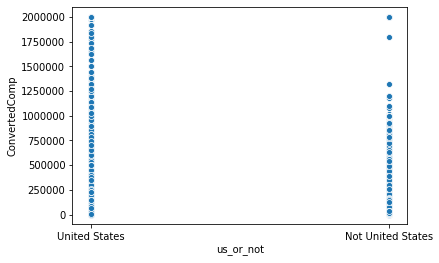

In [36]:
# Plot converted comp with missing values dropped
sns.scatterplot(data = results_analysis_df_comp_drop, x = 'us_or_not', y ='ConvertedComp')


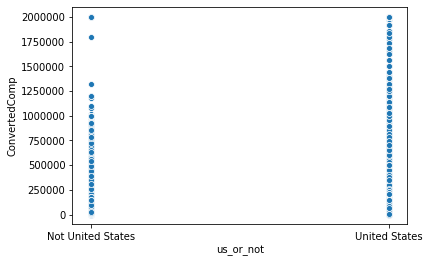

In [37]:
#Plot converted comp with missing values imputed with the countrywise mean
sns.scatterplot(data = results_analysis_df_comp_countrymean, x = 'us_or_not', y = 'ConvertedComp')


It can be noted that the the values are generally much more distributed for U.S. developers vs the rest of the world and the mean is likely higher(this can't be confirmed based on the plot alone)

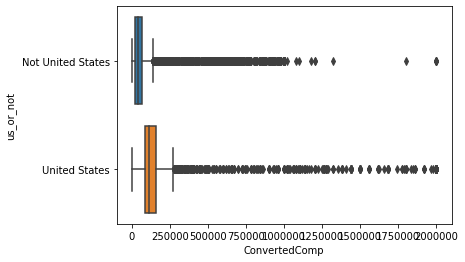

In [38]:
# Plot box plot of results using data frame with dropped values 

sns.boxplot('ConvertedComp','us_or_not', data = results_analysis_df_comp)


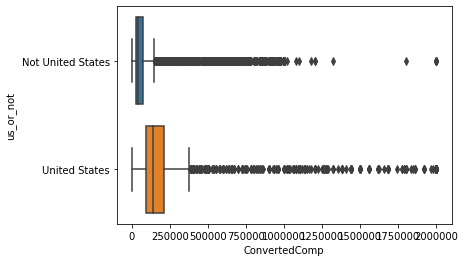

In [39]:
# Plot box plot of results of dataframe that using country mean to handle missing values  
sns.boxplot('ConvertedComp','us_or_not', data = results_analysis_df_comp_countrymean)

##### Result Analysis 
It is clear from the plots below that the U.S. developers are compensated more than developers in other parts of the world. It is clear the developer salaries are higher in the U.S than the rest of the world. There is not as significant difference between the two boxplots other then the standard deviation is higher when the missing values are imputed with the mean

#### Analyze and Plot Job Satisfaction (U.S. vs Not U.S.)

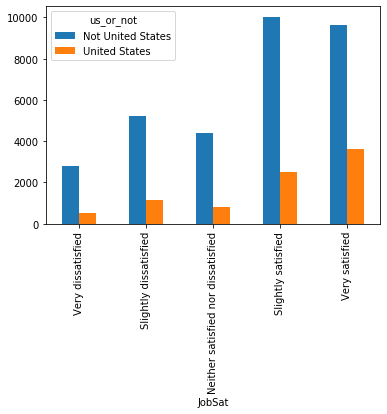

In [81]:
#Explore the data: Plot resonse by country 
df_plot_comp = results_analysis_df_sat.groupby(['us_or_not','JobSat']).size().reset_index().pivot(columns='us_or_not', index='JobSat', values=0)
df_plot_comp.plot(kind='bar', stacked=False)

Clearly Not US has more respondents then only the US so we need to calculate satifaction in terms of a percent

In [41]:
#Explore the data: Aggregate the data so we know how to visualize it later 
aggregated_results_sat = results_analysis_df_sat.groupby(['us_or_not', 'JobSat'], as_index = False)['Respondent'].count()
aggregated_results_sat.head(5)

,us_or_not,JobSat,Respondent
0,Not United States,Very dissatisfied,2811
1,Not United States,Slightly dissatisfied,5228
2,Not United States,Neither satisfied nor dissatisfied,4385
3,Not United States,Slightly satisfied,10044
4,Not United States,Very satisfied,9656


In [42]:
#Explore the data: Aggregate the data so know how to visualize it later
respondent_count_df = results_analysis_df_sat['us_or_not'].value_counts()
respondent_count_df

Not United States    37737
United States         9456
Name: us_or_not, dtype: int64

In [43]:
#Calculate category percentages in each category 
aggregated_results_sat['RespondentPercentage'] = aggregated_results_sat.apply(lambda x: x['Respondent']/respondent_count_df[x['us_or_not']], axis = 1).round(3)
aggregated_results_sat = aggregated_results_sat[['RespondentPercentage','JobSat', 'us_or_not' ]]
aggregated_results_sat.head(5)









,RespondentPercentage,JobSat,us_or_not
0,0.074,Very dissatisfied,Not United States
1,0.139,Slightly dissatisfied,Not United States
2,0.116,Neither satisfied nor dissatisfied,Not United States
3,0.266,Slightly satisfied,Not United States
4,0.256,Very satisfied,Not United States


In [44]:
#Pivot results to plot the results 
pivoted_sat_data = pd.pivot_table(aggregated_results_sat, values = 'RespondentPercentage', index = 'us_or_not', columns = 'JobSat')
pivoted_sat_data.sort_values('Very satisfied', ascending = True)
pivoted_sat_data







JobSat,Very dissatisfied,Slightly dissatisfied,Neither satisfied nor dissatisfied,Slightly satisfied,Very satisfied
us_or_not,,,,,
Not United States,0.074,0.139,0.116,0.266,0.256
United States,0.057,0.122,0.084,0.267,0.384


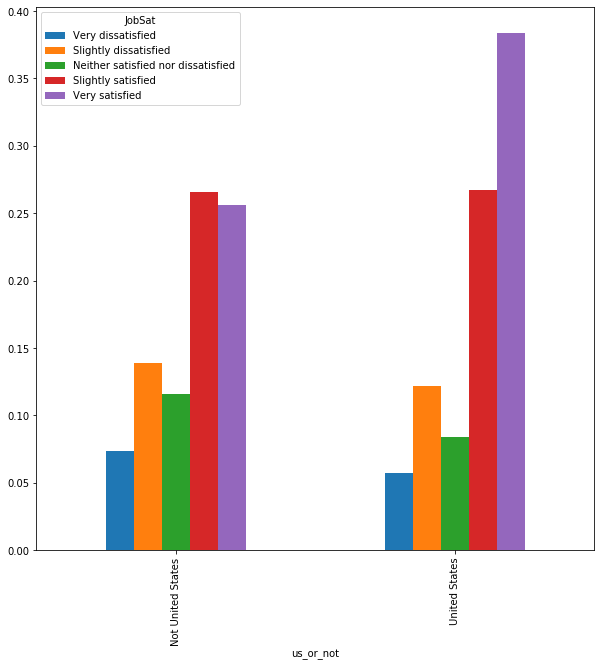

In [45]:
#Plot category percentages using a standard side by side bar chart
pivoted_sat_data.plot(kind='bar', stacked=False, figsize=(10,10))

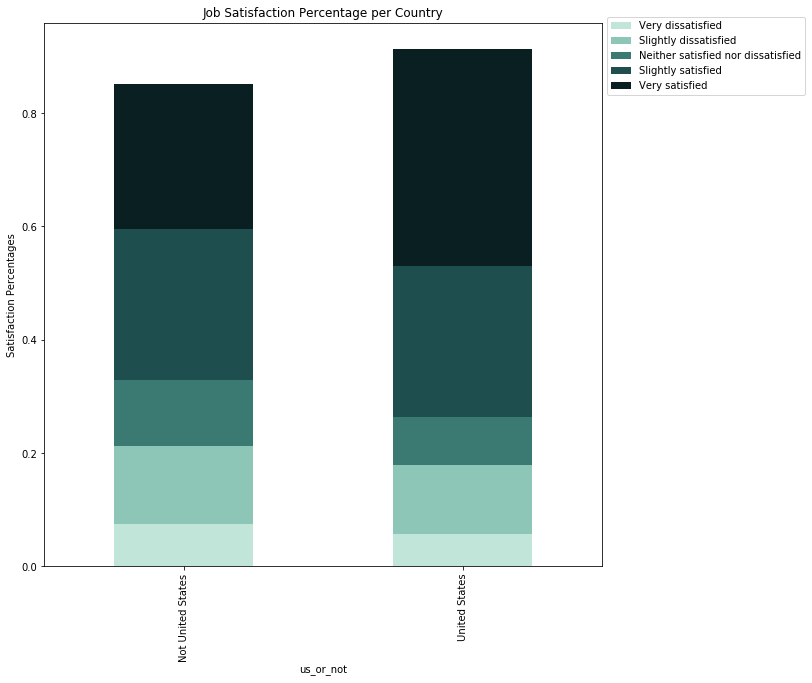

In [46]:
#Plot category percentages using a stacked bar chart
pivoted_sat_data.plot(kind='bar', 
                  stacked=True, 
                  colormap=ListedColormap(sns.color_palette("ch:5.5,-.1,dark=.1")),
                  figsize=(10,10))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.ylabel('Satisfaction Percentages')
plt.title('Job Satisfaction Percentage per Country')
plt.show()

##### Result Analysis 
It is clear from the plots below that the U.S. has a higher percentage of very satified developers and a higher developer satisfaction overall 

#### Analyze and Plot Job Search Patterns 

In [47]:
#Explore dataframe
results_analysis_df_js

,Country,JobSat,ConvertedComp,NEWJobHunt,Respondent,us_or_not
7,United States,Slightly dissatisfied,116000.0,Curious about other opportunities;Better compe...,8,United States
9,United Kingdom,Very satisfied,32315.0,Curious about other opportunities;Better compe...,10,Not United States
10,United Kingdom,Slightly dissatisfied,40070.0,Curious about other opportunities;Better compe...,11,Not United States
11,Spain,Very dissatisfied,14268.0,Better compensation,12,Not United States
13,United States,Slightly satisfied,66000.0,Wanting to share accomplishments with a wider ...,14,United States
...,...,...,...,...,...,...
64100,Australia,Slightly dissatisfied,80172.0,Curious about other opportunities;Better compe...,65571,Not United States
64111,India,Very satisfied,2508.0,Better compensation,65584,Not United States
64148,Colombia,Slightly satisfied,19428.0,Having a bad day (or week or month) at work;Cu...,65625,Not United States
64152,United States,Very satisfied,200.0,Curious about other opportunities;Better compe...,65629,United States


In [48]:
#Check different unique response options in the for NEWJobHunt by spitting them out and checking unique
results_analysis_df_js_split = results_analysis_df_js.NEWJobHunt.str.split(";",expand=True)
results_analysis_df_js_split = results_analysis_df_js_split.applymap(str)
results_analysis_df_js_unique = np.unique(results_analysis_df_js_split[[0,1,2,3,4,5,6,7,8,9,10,11]].values)
list(results_analysis_df_js_unique)
# Set the JobSat column into categorical data type so it will be sorted with the right order (ordinal data)

['Better compensation',
 'Better work/life balance',
 'Curious about other opportunities',
 'Growth or leadership opportunities',
 'Having a bad day (or week or month) at work',
 'Just because',
 'Looking to relocate',
 'None',
 'Trouble with leadership at my company',
 'Trouble with my direct manager',
 'Trouble with my teammates',
 'Wanting to share accomplishments with a wider network',
 'Wanting to work with new technologies']

In [49]:
#Explore Data Frame Further
results_analysis_df_js

,Country,JobSat,ConvertedComp,NEWJobHunt,Respondent,us_or_not
7,United States,Slightly dissatisfied,116000.0,Curious about other opportunities;Better compe...,8,United States
9,United Kingdom,Very satisfied,32315.0,Curious about other opportunities;Better compe...,10,Not United States
10,United Kingdom,Slightly dissatisfied,40070.0,Curious about other opportunities;Better compe...,11,Not United States
11,Spain,Very dissatisfied,14268.0,Better compensation,12,Not United States
13,United States,Slightly satisfied,66000.0,Wanting to share accomplishments with a wider ...,14,United States
...,...,...,...,...,...,...
64100,Australia,Slightly dissatisfied,80172.0,Curious about other opportunities;Better compe...,65571,Not United States
64111,India,Very satisfied,2508.0,Better compensation,65584,Not United States
64148,Colombia,Slightly satisfied,19428.0,Having a bad day (or week or month) at work;Cu...,65625,Not United States
64152,United States,Very satisfied,200.0,Curious about other opportunities;Better compe...,65629,United States


In [50]:
#Create Columns for the different job search types with an binary variable noting the true and false for each variable type
results_analysis_df_list=results_analysis_df_js
for curr_string in list(results_analysis_df_js_unique):
    results_analysis_df_list[curr_string]= results_analysis_df_js["NEWJobHunt"].str.contains(curr_string).astype(int)
results_analysis_df_list.head(10)

,Country,JobSat,ConvertedComp,NEWJobHunt,Respondent,us_or_not,Better compensation,Better work/life balance,Curious about other opportunities,Growth or leadership opportunities,Having a bad day (or week or month) at work,Just because,Looking to relocate,None,Trouble with leadership at my company,Trouble with my direct manager,Trouble with my teammates,Wanting to share accomplishments with a wider network,Wanting to work with new technologies
7,United States,Slightly dissatisfied,116000.0,Curious about other opportunities;Better compe...,8,United States,1,1,1,1,0,0,0,0,1,1,0,0,1
9,United Kingdom,Very satisfied,32315.0,Curious about other opportunities;Better compe...,10,Not United States,1,0,1,0,0,0,1,0,0,0,0,0,0
10,United Kingdom,Slightly dissatisfied,40070.0,Curious about other opportunities;Better compe...,11,Not United States,1,1,1,1,0,0,0,0,1,0,0,0,1
11,Spain,Very dissatisfied,14268.0,Better compensation,12,Not United States,1,0,0,0,0,0,0,0,0,0,0,0,0
13,United States,Slightly satisfied,66000.0,Wanting to share accomplishments with a wider ...,14,United States,1,0,1,1,0,0,0,0,0,0,0,1,1
15,United Kingdom,Very satisfied,108576.0,Having a bad day (or week or month) at work;Cu...,16,Not United States,1,0,1,0,0,0,0,0,1,1,0,0,0
16,United States,Slightly dissatisfied,79000.0,Having a bad day (or week or month) at work;Be...,17,United States,1,0,0,1,0,0,0,0,1,0,0,0,1
17,United States,Very satisfied,1260000.0,Looking to relocate,18,United States,0,0,0,0,0,0,1,0,0,0,0,0,0
18,United States,Slightly dissatisfied,83400.0,Having a bad day (or week or month) at work;Tr...,19,United States,0,0,0,1,0,0,0,0,0,0,1,0,0
23,Germany,Very satisfied,91883.0,Having a bad day (or week or month) at work;Cu...,24,Not United States,0,0,1,0,0,0,0,0,0,0,0,0,1


In [51]:
#Create data frame for responses for both US and None US
results_analysis_df_list_us = results_analysis_df_list[results_analysis_df_list['us_or_not'] == 'United States']
results_analysis_df_list_nus = results_analysis_df_list[results_analysis_df_list['us_or_not'] == 'Not United States']

In [26]:
#Get totals of US reponses to calculate percentages 
df_job_hunt_totals_us = results_analysis_df_list_us.count()
df_job_hunt_totals_us


Country                                                  6833
JobSat                                                   6833
ConvertedComp                                            6833
NEWJobHunt                                               6833
Respondent                                               6833
us_or_not                                                6833
Better compensation                                      6833
Better work/life balance                                 6833
Curious about other opportunities                        6833
Growth or leadership opportunities                       6833
Having a bad day (or week or month) at work              6833
Just because                                             6833
Looking to relocate                                      6833
None                                                     6833
Trouble with leadership at my company                    6833
Trouble with my direct manager                           6833
Trouble 

In [27]:
#Sum responses for each category for US responses to calculate percentages
df_job_hunt_totals_grouped_us = results_analysis_df_list_us.groupby('us_or_not').sum()
df_job_hunt_totals_grouped_us
#df_res


,ConvertedComp,Respondent,Better compensation,Better work/life balance,Curious about other opportunities,Growth or leadership opportunities,Having a bad day (or week or month) at work,Just because,Looking to relocate,None,Trouble with leadership at my company,Trouble with my direct manager,Trouble with my teammates,Wanting to share accomplishments with a wider network,Wanting to work with new technologies
us_or_not,,,,,,,,,,,,,,,
United States,1.426303e+09,189211729,5099,2816,4141,4130,0,988,1687,0,2520,1567,1011,434,3872


In [28]:
#Divide the number in each category by the total number of responses for US reponses only to calculate percentages
df_job_hunt_totals_grouped_us = df_job_hunt_totals_grouped_us.div(df_job_hunt_totals_us, axis = 1)
df_job_hunt_totals_grouped_us

,Better compensation,Better work/life balance,ConvertedComp,Country,Curious about other opportunities,Growth or leadership opportunities,Having a bad day (or week or month) at work,JobSat,Just because,Looking to relocate,NEWJobHunt,None,Respondent,Trouble with leadership at my company,Trouble with my direct manager,Trouble with my teammates,Wanting to share accomplishments with a wider network,Wanting to work with new technologies,us_or_not
us_or_not,,,,,,,,,,,,,,,,,,,
United States,0.746232,0.412118,208737.378457,NaN,0.60603,0.60442,0.0,NaN,0.144592,0.24689,NaN,0.0,27690.872091,0.368798,0.229328,0.147958,0.063515,0.566662,NaN


In [29]:
#Drop empty columns
df_job_hunt_totals_grouped_us.dropna(axis = 1, inplace = True)
df_job_hunt_totals_grouped_us.drop(labels = ['ConvertedComp', 'Respondent', 'None' ], axis = 1, inplace = True)
df_job_hunt_totals_grouped_us

,Better compensation,Better work/life balance,Curious about other opportunities,Growth or leadership opportunities,Having a bad day (or week or month) at work,Just because,Looking to relocate,Trouble with leadership at my company,Trouble with my direct manager,Trouble with my teammates,Wanting to share accomplishments with a wider network,Wanting to work with new technologies
us_or_not,,,,,,,,,,,,
United States,0.746232,0.412118,0.60603,0.60442,0.0,0.144592,0.24689,0.368798,0.229328,0.147958,0.063515,0.566662


In [30]:
# Compute totals and the number of responses in each category for none us respondents and calculate percentage
df_job_hunt_totals_nus = results_analysis_df_list_nus.count()
df_job_hunt_totals_grouped_nus = results_analysis_df_list_nus.groupby('us_or_not').sum()
df_job_hunt_totals_grouped_nus = df_job_hunt_totals_grouped_nus.div(df_job_hunt_totals_nus, axis = 1)
df_job_hunt_totals_grouped_nus.dropna(axis = 1, inplace = True)
df_job_hunt_totals_grouped_nus.drop(labels = ['ConvertedComp', 'Respondent', 'None' ], axis = 1, inplace = True)
df_job_hunt_totals_grouped = pd.concat([df_job_hunt_totals_grouped_us, df_job_hunt_totals_grouped_nus], axis = 0)

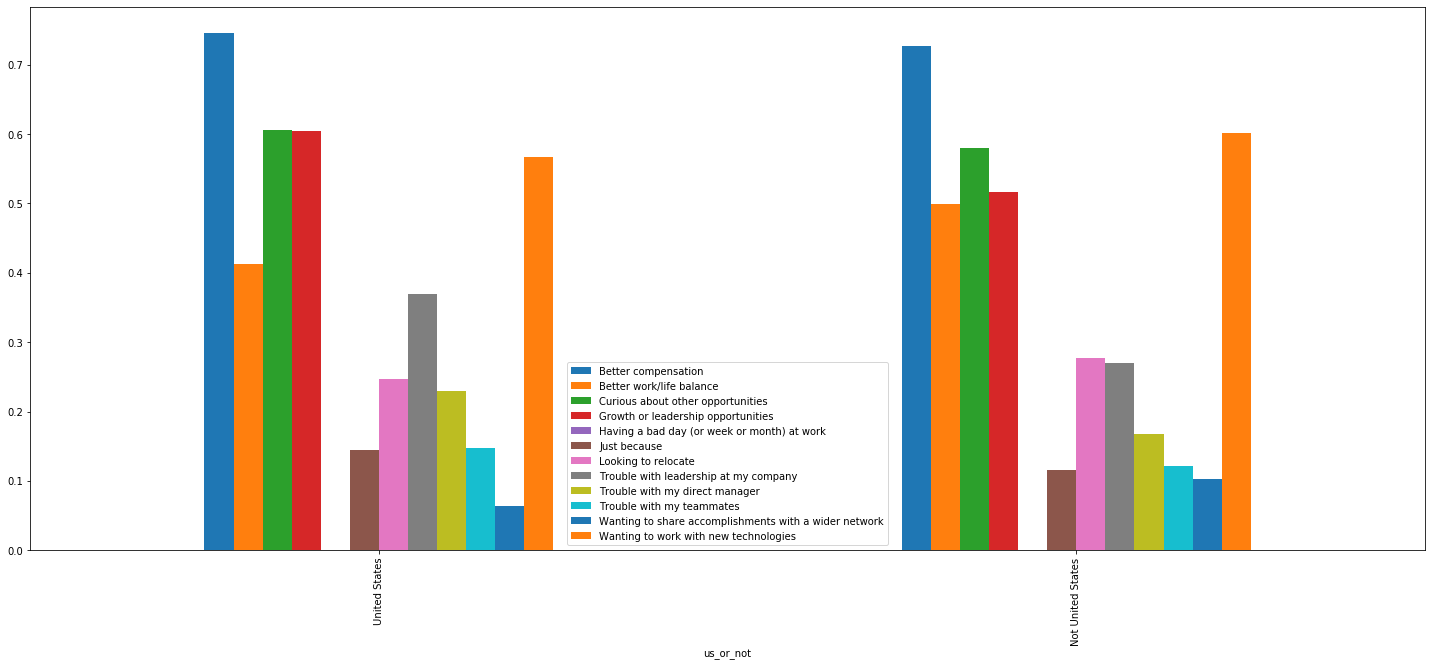

In [31]:
# Plot percentages in each category for US and None US responses.
df_job_hunt_totals_grouped.plot(kind='bar', stacked=False, figsize=(25,10))

##### Result Analysis 
It is clear from the plots above that the U.S. has a higher percentage of developers look to change roles as the result of trouble with their leadership